<a href="https://colab.research.google.com/github/jumafernandez/clasificacion_correos/blob/main/notebooks/jaiio/03-modelos/01-etiquetado_manual%2Bsvm-vFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Baseline JAIIO: Etiquetado manual+SVM

En esta notebook se presetan los experimentos sobre la estrategia de representación y técnica de aprendizaje baseline utilizada para el trabajo de investigación con los correos etiquetados de forma manual.

Para ello vamos a preprocesar los correos y aplicar:
- Bag of words,
- Pesado binario/no binario,
- Máquina de vector soporte (SVM).

## 0. Configuración de la ejecución

A continuación se genera la configuración de las estrategias que integrarán el sistema de votación para la obtención de instancias:

In [35]:
# Defino una lista con los esquemas de representación y la cantidad de tokens
estrategias_representacion = ['BINARIO', 'TFIDF', '3-4-NGRAM-CHARS', '1-2-NGRAM-WORDS']
ATRIBUTOS_DINAMICOS = 3000

# Defino la técnica de ML
tecnica = 'SVM'

Se definen algunas características fijas:

In [36]:
# El archivo de test y el train con etiquetado manual es siempre el mismo
TEST_FILE = 'correos-test-jaiio-20.csv'
TRAIN_FILE_MANUAL = 'correos-train-jaiio-80.csv'
atributos_df = ['consulta', 'dia_semana', 'semana_del_mes', 'mes', 'cuatrimestre',
                  'anio', 'hora_discretizada', 'dni_discretizado', 'legajo_discretizado',
                  'posee_legajo', 'posee_telefono', 'carrera_valor', 'proveedor_correo',
                  'cantidad_caracteres', 'proporcion_mayusculas', 'proporcion_letras',
                  'cantidad_tildes', 'cantidad_palabras', 'cantidad_palabras_cortas',
                  'proporcion_palabras_distintas', 'frecuencia_signos_puntuacion',
                  'cantidad_oraciones', 'utiliza_codigo_asignatura', 'score', 'clase_e0']

## 1. Instalación y Carga de librerías y funciones útiles

### 1.1 Instalación de librerías

Se instalan las librerías que no están en el entorno de Google Colab:

In [37]:
# Se instala gensim que es el que tiene el modelo Word2Vec
!pip install requests
!pip install wget

### 1.2 Funciones útiles

Se cargan funciones útiles desde el repo https://github.com/jumafernandez/clasificacion_correos para la carga y balanceo del dataset.

In [38]:
import requests

# Se hace el request del raw del script python
url = 'https://raw.githubusercontent.com/jumafernandez/clasificacion_correos/main/scripts/funciones_dataset.py'
r = requests.get(url)

# Se guarda en el working directory
with open('funciones_dataset.py', 'w') as f:
    f.write(r.text)

# Se importan las funciones a utilizar
from funciones_dataset import get_clases, cargar_dataset, consolidar_df, generar_train_test_set

También se carga la función para preprocesar el texto que se usó en los otros modelos desde el repo: https://github.com/jumafernandez/clasificacion_correos.

In [39]:
import requests

# Se hace el request del raw del script python
url = 'https://raw.githubusercontent.com/jumafernandez/clasificacion_correos/main/scripts/funciones_preprocesamiento.py'
r = requests.get(url)

# Se guarda en el working directory
with open('funciones_preprocesamiento.py', 'w') as f:
    f.write(r.text)

# Se importan las funciones a utilizar
from funciones_preprocesamiento import preprocesar_correos

### 1.2.1. Carga de librerías de procesamiento de texto

Se cargan en memoria dos funciones: _grid_search_por_estrategia_representacion_ que va a iterar ajustando los hiperparámetros para las técnica de __SVM__ y _representacion_documentos_ que genera representaciones para las _features textuales_:

In [40]:
import requests

# Se hace el request del raw del script python
url = 'https://raw.githubusercontent.com/jumafernandez/clasificacion_correos/main/scripts/funciones_clasificacion_texto.py'
r = requests.get(url)

# Se guarda en el working directory
with open('funciones_clasificacion_texto.py', 'w') as f:
    f.write(r.text)

# Se importan las funciones a utilizar
from funciones_clasificacion_texto import gridsearch_por_estrategia_representacion, representacion_documentos, gridsearch_por_tecnica

### 1.3. Carga de datos

Cargo la librería warnings para no mostrar las advertencias, pandas para el manejo de df y os para verificar la existencia de los archivos en la carga de datos. Además, cargo en memoria la URL de base de los datasets y una lista de las etiquetas de las distintas clases:

In [41]:
import warnings
import pandas as pd
from os import path
warnings.filterwarnings("ignore")

# Constantes con los datos
DS_DIR = 'https://raw.githubusercontent.com/jumafernandez/clasificacion_correos/main/data/50jaiio/consolidados/'

# Defino las clases y la cantidad a utilizar
etiquetas = get_clases()
CANTIDAD_CLASES = len(etiquetas)

In [42]:
# Chequeo sobre si los archivos están en el working directory
download_files = not(path.exists(TRAIN_FILE_MANUAL))

train_df, test_df, etiquetas = cargar_dataset(DS_DIR, TRAIN_FILE_MANUAL, TEST_FILE, download_files, 'clase', etiquetas, CANTIDAD_CLASES, 'Otras Consultas')

# Se ejecuta el preprocesamiento de correos sobre el campo Consulta de train y test
train_df['consulta'] = pd.Series(preprocesar_correos(train_df['consulta']))

# Muestro salida por consola
print('Existen {} clases: {}.'.format(len(train_df.clase.unique()), train_df.clase.unique()))


El conjunto de entrenamiento tiene la dimensión: (800, 24)
El conjunto de testeo tiene la dimensión: (200, 24)
Existen 16 clases: ['Boleto Universitario' 'Problemas con la Clave' 'Cursadas'
 'Cambio de Carrera' 'Ingreso a la Universidad' 'Requisitos de Ingreso'
 'Reincorporación' 'Pedido de Certificados' 'Situación Académica'
 'Exámenes' 'Cambio de Comisión' 'Consulta por Legajo'
 'Consulta sobre Título Universitario' 'Datos Personales'
 'Consulta por Equivalencias' 'Simultaneidad de Carreras'].


Muestro el dataframe resultante:

In [43]:
# pd.set_option('display.max_colwidth', None)
# pd.set_option('display.max_rows', None)
train_df.shape

(800, 24)

In [44]:
X_train, y_train, X_test, y_test = generar_train_test_set(train_df, test_df, '3-4-NGRAM-CHARS', MAX_TKS=ATRIBUTOS_DINAMICOS)

Estrategia de representación: 3-4-NGRAM-CHARS


In [45]:
X_train.shape

(800, 3022)

## 2. SVM

### 2.1 Modelo general (clasificación en las 16 clases)

En primer lugar se trabaja con un único clasificador que clasifica y testea las instancias en las 16 clases posibles.

#### 2.1.1 Definición del espacio de búsqueda

Se define el espacio de búsqueda para el ajuste de hiperparámetros del modelo:

In [46]:
# Defino los parámetros para GridSearchCV
params_svm = {'SVM__C': [0.1, 1, 10], 
              'SVM__gamma': [0.01, 0.1, 1],
              'SVM__class_weight': [None, 'balanced'],
              'SVM__kernel': ['rbf', 'linear', 'sigmoid'],
              'SVM__probability': [False]
              }

Se ejecuta el ajuste de hiperparámetros para cada estrategia de representación en función del espacio de búsqueda:

In [47]:
modelos_grid = []
representacion_grid = []
metricas_grid = []
NO_CORRIDA = True

if NO_CORRIDA:
  # Se hace una búsqueda grid por estrategia de representación
  for estrategia in estrategias_representacion:
    
    # Generamos los datos de train y test por estrategia
    X_train, y_train, X_test, y_test = generar_train_test_set(train_df, test_df, estrategia, MAX_TKS=ATRIBUTOS_DINAMICOS)
    
    # Llamo a la función que realiza el gridsearch por estrategia  
    clf_grid, metrics_grid = gridsearch_por_tecnica(X_train, y_train, X_test, y_test, tecnica, params_svm)

    # Guardamos el mejor modelo para cada estrategia de representación
    modelos_grid.append(clf_grid)
    representacion_grid.append(estrategia)
    metricas_grid.append(metrics_grid)

Estrategia de representación: BINARIO
Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   39.7s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:  6.7min finished


Parámetros: {'SVM__C': 10, 'SVM__class_weight': 'balanced', 'SVM__gamma': 0.01, 'SVM__kernel': 'sigmoid', 'SVM__probability': False}
Accuracy Test-Set: 0.745
Métricas sobre Test-Set: {'accuracy': 0.745, 'precision': 0.7473571428571428, 'recall': 0.745, 'f1_score': 0.7382868301819316, 'mcc': 0.7095105249896024}
Estrategia de representación: TFIDF
Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   40.7s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:  7.5min finished


Parámetros: {'SVM__C': 10, 'SVM__class_weight': 'balanced', 'SVM__gamma': 0.1, 'SVM__kernel': 'sigmoid', 'SVM__probability': False}
Accuracy Test-Set: 0.7
Métricas sobre Test-Set: {'accuracy': 0.7, 'precision': 0.7190727687626775, 'recall': 0.7, 'f1_score': 0.6963380927317745, 'mcc': 0.6578107705206261}
Estrategia de representación: 3-4-NGRAM-CHARS
Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed: 10.3min finished


Parámetros: {'SVM__C': 0.1, 'SVM__class_weight': 'balanced', 'SVM__gamma': 0.01, 'SVM__kernel': 'linear', 'SVM__probability': False}
Accuracy Test-Set: 0.8
Métricas sobre Test-Set: {'accuracy': 0.8, 'precision': 0.7936884574519464, 'recall': 0.8, 'f1_score': 0.7911445565762963, 'mcc': 0.7708036472669705}
Estrategia de representación: 1-2-NGRAM-WORDS
Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed: 11.6min finished


Parámetros: {'SVM__C': 10, 'SVM__class_weight': 'balanced', 'SVM__gamma': 0.1, 'SVM__kernel': 'sigmoid', 'SVM__probability': False}
Accuracy Test-Set: 0.72
Métricas sobre Test-Set: {'accuracy': 0.72, 'precision': 0.7417318306693307, 'recall': 0.72, 'f1_score': 0.7200297549529311, 'mcc': 0.6800532077731802}


A partir de los mejores hiperparámetros encontrados para cada estrategia de representación de correos, se busca cual es la estrategia que generó el mayor _accuracy_ (medida totalmente arbitraria):

In [48]:
max_accuracy = 0
for i in range(1, len(metricas_grid)):
  if metricas_grid[i]['accuracy'] > metricas_grid[max_accuracy]['accuracy']:
    max_accuracy = i

representacion_max = representacion_grid[max_accuracy]

# Se le quita el prefijo asignado a los parametricos para la búsqueda grid
params_max = params = {x.replace("SVM__", ""): v for x, v in modelos_grid[max_accuracy].best_params_.items()}

metricas_max = metricas_grid[max_accuracy]

print(f'El modelo más eficaz es {tecnica} con la estrategia de representación {representacion_max} y los parámetros:\n {params_max}')
print(f'El modelo brinda las siguientes métricas de selección:\n {metricas_max}')

El modelo más eficaz es SVM con la estrategia de representación 3-4-NGRAM-CHARS y los parámetros:
 {'C': 0.1, 'class_weight': 'balanced', 'gamma': 0.01, 'kernel': 'linear', 'probability': False}
El modelo brinda las siguientes métricas de selección:
 {'accuracy': 0.8, 'precision': 0.7936884574519464, 'recall': 0.8, 'f1_score': 0.7911445565762963, 'mcc': 0.7708036472669705}


#### 2.1.2 Modelo generado

En función de los mejores hiperparámetros y estrategia de representación encontrados con la búsqueda Grid, ajusto el modelo para obtener las métricas.

En primer lugar se generan nuevamente los datos de train y test en función de la mejor estrategia de representación encontrada:

In [55]:
X_train, y_train, X_test, y_test = generar_train_test_set(train_df, test_df, representacion_max, MAX_TKS=ATRIBUTOS_DINAMICOS)

Estrategia de representación: 3-4-NGRAM-CHARS


Se entrena el modelo con los mejores hiperparámetros encontrados:

In [56]:
from sklearn.svm import SVC
clf = SVC(**params_max)

# Entreno el modelo con los parámetros
clf.fit(X_train, y_train)

SVC(C=0.1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

Se predicen las instancias de testeo:

In [57]:
y_pred = clf.predict(X_test)

#### 2.1.3 Métricas de selección

In [58]:
from sklearn import metrics #Importar el módulo metrics de scikit-learn

# Vamos a testear el modelo
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

# Vemos un reporte de clasificación de varias métricas
print(metrics.classification_report(y_test, y_pred))

Accuracy: 0.8
                                     precision    recall  f1-score   support

               Boleto Universitario       0.98      0.98      0.98        48
                  Cambio de Carrera       0.00      0.00      0.00         2
                 Cambio de Comisión       0.00      0.00      0.00         2
         Consulta por Equivalencias       1.00      0.67      0.80         3
                Consulta por Legajo       0.50      0.67      0.57         3
Consulta sobre Título Universitario       0.50      0.33      0.40         3
                           Cursadas       0.57      0.89      0.69        19
                   Datos Personales       0.00      0.00      0.00         2
                           Exámenes       0.60      0.60      0.60         5
           Ingreso a la Universidad       0.90      0.79      0.84        33
             Pedido de Certificados       0.88      1.00      0.94        15
             Problemas con la Clave       0.90      0.83     

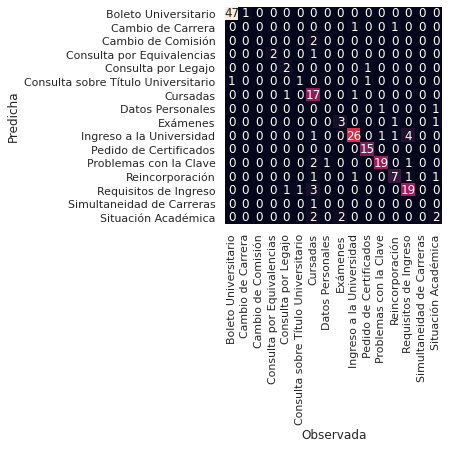

In [59]:
import numpy as np
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

mat = metrics.confusion_matrix(y_test, y_pred)

sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=etiquetas, yticklabels=etiquetas)

plt.xlabel('Observada')
plt.ylabel('Predicha');

### 3. Análisis del error

A continuación se intentan entender los errores del modelo a partir del etiquetado manual.

Genero un dataframe con los scores promedios por clase, el accuracy por clase y el _count_:

In [61]:
df_error = train_df.groupby(['clase']).mean().reset_index()
# Accuracy por clase
avg_class = mat.diagonal()/mat.sum(axis=1)
df_error['accuracy'] = pd.Series(avg_class)

df_error['count'] = mat.sum(axis=1)

df_error

,clase,dia_semana,semana_del_mes,mes,cuatrimestre,anio,hora_discretizada,dni_discretizado,legajo_discretizado,posee_legajo,posee_telefono,carrera_valor,proveedor_correo,cantidad_caracteres,proporcion_mayusculas,proporcion_letras,cantidad_tildes,cantidad_palabras,cantidad_palabras_cortas,proporcion_palabras_distintas,frecuencia_signos_puntuacion,cantidad_oraciones,utiliza_codigo_asignatura,accuracy,count
0,Boleto Universitario,2.010363,2.404145,5.005181,1.233161,2018.668394,1.435233,5.134715,3.010363,0.968912,0.870466,22.274611,5.398964,206.202073,0.0,0.799862,1.880829,37.487047,20.554404,0.866672,0.019141,2.025907,0.000000,0.979167,48
1,Cambio de Carrera,2.636364,2.363636,6.000000,1.454545,2017.000000,1.000000,3.909091,1.454545,0.636364,0.818182,18.909091,5.090909,196.454545,0.0,0.794343,1.363636,35.909091,19.727273,0.868325,0.022300,2.363636,0.000000,0.000000,2
2,Cambio de Comisión,3.375000,2.250000,4.125000,1.250000,2017.500000,1.625000,3.750000,2.625000,0.875000,0.875000,30.000000,6.375000,157.875000,0.0,0.818167,1.125000,26.750000,11.625000,0.926576,0.017620,1.250000,0.000000,0.000000,2
3,Consulta por Equivalencias,2.300000,2.500000,5.800000,1.300000,2017.000000,1.500000,3.000000,2.600000,1.000000,0.700000,35.700000,6.600000,220.800000,0.0,0.808073,2.900000,36.300000,18.000000,0.847970,0.026034,2.500000,0.000000,0.666667,3
4,Consulta por Legajo,2.066667,2.466667,3.600000,1.133333,2017.066667,1.800000,4.066667,0.400000,0.133333,0.733333,25.800000,4.800000,140.333333,0.0,0.799403,1.466667,25.333333,12.933333,0.900831,0.024661,1.800000,0.000000,0.666667,3
5,Consulta sobre Título Universitario,1.800000,3.400000,8.900000,1.600000,2016.200000,1.100000,2.700000,1.700000,1.000000,0.700000,22.700000,6.300000,253.100000,0.0,0.789879,3.800000,45.800000,24.400000,0.819777,0.023787,3.700000,0.100000,0.333333,3
6,Cursadas,1.906667,2.413333,4.693333,1.293333,2017.613333,1.733333,4.413333,1.186667,0.493333,0.853333,23.053333,5.533333,156.800000,0.0,0.802139,1.213333,28.493333,15.506667,0.892676,0.017356,1.840000,0.040000,0.894737,19
7,Datos Personales,2.666667,2.166667,5.333333,1.333333,2017.166667,2.000000,3.166667,1.333333,0.666667,0.833333,22.333333,5.833333,179.333333,0.0,0.797129,1.666667,30.666667,15.000000,0.845499,0.015330,1.500000,0.000000,0.000000,2
8,Exámenes,2.277778,2.555556,6.333333,1.333333,2017.277778,1.666667,4.722222,2.111111,0.833333,0.777778,24.277778,6.055556,156.277778,0.0,0.798328,1.888889,28.000000,14.611111,0.896780,0.022079,1.500000,0.000000,0.600000,5
9,Ingreso a la Universidad,2.288889,2.511111,6.518519,1.488889,2017.711111,1.555556,5.000000,0.111111,0.059259,0.851852,19.511111,5.474074,159.792593,0.0,0.799018,1.533333,29.429630,16.837037,0.885470,0.017181,1.911111,0.000000,0.787879,33


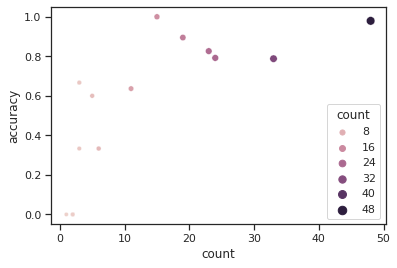

In [62]:
import seaborn as sns
sns.set_theme(style="ticks")

sns.scatterplot(data=df_error, x="count", y="accuracy", hue="count", size="count")

## Referencias
- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
- https://medium.com/analytics-vidhya/ml-pipelines-using-scikit-learn-and-gridsearchcv-fe605a7f9e05